In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/twitter-entity-sentiment-analysis/twitter_validation.csv
/kaggle/input/twitter-entity-sentiment-analysis/twitter_training.csv
/kaggle/input/sentiment-analysis-dataset/training.1600000.processed.noemoticon.csv
/kaggle/input/sentiment-analysis-dataset/train.csv
/kaggle/input/sentiment-analysis-dataset/testdata.manual.2009.06.14.csv
/kaggle/input/sentiment-analysis-dataset/test.csv


In [2]:
# ============================================================================
# SECTION 1: SETUP & INSTALLATIONS
# ============================================================================

print("="*70)
print("SENTIMENT ANALYSIS - KAGGLE TRAINING PIPELINE")
print("="*70)
print("\n🚀 Starting setup...\n")

# Install additional packages
import sys
!{sys.executable} -m pip install -q transformers datasets emoji textblob imbalanced-learn wordcloud

print("✅ Packages installed!\n")

SENTIMENT ANALYSIS - KAGGLE TRAINING PIPELINE

🚀 Starting setup...

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 43.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 106.7 MB/s eta 0:00:0000:010:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
pylibcudf-cu12 25.2.2 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 22.0.0 which is incompatible.
cudf-cu12 25.2.2 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 22.0.0 which is incompatible.
category-encoders 2.7.0 requires scikit-learn<1.6.0,>=1.0.0, but you have scikit-learn 1.6.1 which is incompatible.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
bigf

In [3]:
# Import libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, confusion_matrix, 
                             accuracy_score, precision_recall_fscore_support)

import nltk
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('omw-1.4', quiet=True)

print("✅ Libraries imported!\n")

# Set style
plt.style.use('default')
sns.set_palette("husl")

✅ Libraries imported!



In [4]:
# SECTION 2: LOAD KAGGLE INPUT DATASETS
# ============================================================================

print("="*70)
print("LOADING KAGGLE INPUT DATASETS")
print("="*70)

# Kaggle input paths
KAGGLE_INPUT_PATH = '/kaggle/input'

print("\n📁 Available input datasets:")
if os.path.exists(KAGGLE_INPUT_PATH):
    for item in os.listdir(KAGGLE_INPUT_PATH):
        print(f"   • {item}")
else:
    print("   ⚠️  No input datasets found. Please add datasets using 'Add Data' button.")

# Common dataset paths
DATASET_PATHS = {
    'sentiment-analysis-dataset': f'{KAGGLE_INPUT_PATH}/sentiment-analysis-dataset',
    'twitter-entity-sentiment-analysis': f'{KAGGLE_INPUT_PATH}/twitter-entity-sentiment-analysis',
    'twitter-sentiment-analysis': f'{KAGGLE_INPUT_PATH}/twitter-sentiment-analysis',
}

# Find available dataset
df = None
dataset_name = None

for name, path in DATASET_PATHS.items():
    if os.path.exists(path):
        print(f"\n✅ Found dataset: {name}")
        print(f"   Path: {path}")
        
        # List files
        files = []
        for root, dirs, filenames in os.walk(path):
            for filename in filenames:
                if filename.endswith('.csv'):
                    files.append(os.path.join(root, filename))
        
        print(f"   CSV files found: {len(files)}")
        for f in files:
            print(f"      • {os.path.basename(f)}")
        
        if files:
            # Try to load the first CSV
            try:
                print(f"\n   Loading: {files[0]}")
                df = pd.read_csv(files[0])
                dataset_name = name
                print(f"   ✅ Successfully loaded!")
                print(f"   Shape: {df.shape}")
                print(f"   Columns: {df.columns.tolist()}")
                break
            except Exception as e:
                print(f"   ❌ Error loading: {e}")
                # Try without header
                try:
                    df = pd.read_csv(files[0], header=None)
                    dataset_name = name
                    print(f"   ✅ Loaded without headers")
                    print(f"   Shape: {df.shape}")
                    break
                except:
                    continue

if df is None:
    print("\n⚠️  No datasets found in /kaggle/input/")
    print("Creating sample dataset for demonstration...")
    
    # Create sample dataset
    df = pd.DataFrame({
        'text': [
            "I absolutely love this product! It's amazing!",
            "This is the worst experience ever. Terrible!",
            "It's okay, nothing special.",
            "Amazing quality! Highly recommend!",
            "Disappointed. Does not work as advertised.",
            "Decent product for the price.",
            "Fantastic! Will buy again!",
            "Awful quality. Very disappointed.",
            "Good value for money.",
            "Terrible customer service.",
        ] * 150,  # Create larger dataset
        'sentiment': ['positive', 'negative', 'neutral', 'positive', 'negative',
                     'neutral', 'positive', 'negative', 'neutral', 'negative'] * 150
    })
    print(f"✅ Created sample dataset: {df.shape[0]} rows")
    dataset_name = 'sample-dataset'

print(f"\n📊 Dataset loaded: {dataset_name}")
print(f"   Size: {df.shape}")
print("\n   First few rows:")
print(df.head())

LOADING KAGGLE INPUT DATASETS

📁 Available input datasets:
   • twitter-entity-sentiment-analysis
   • sentiment-analysis-dataset

✅ Found dataset: sentiment-analysis-dataset
   Path: /kaggle/input/sentiment-analysis-dataset
   CSV files found: 4
      • training.1600000.processed.noemoticon.csv
      • train.csv
      • testdata.manual.2009.06.14.csv
      • test.csv

   Loading: /kaggle/input/sentiment-analysis-dataset/training.1600000.processed.noemoticon.csv
   ❌ Error loading: 'utf-8' codec can't decode byte 0xa0 in position 17: invalid start byte

✅ Found dataset: twitter-entity-sentiment-analysis
   Path: /kaggle/input/twitter-entity-sentiment-analysis
   CSV files found: 2
      • twitter_validation.csv
      • twitter_training.csv

   Loading: /kaggle/input/twitter-entity-sentiment-analysis/twitter_validation.csv
   ✅ Successfully loaded!
   Shape: (999, 4)
   Columns: ['3364', 'Facebook', 'Irrelevant', 'I mentioned on Facebook that I was struggling for motivation to go for a 


DATA PREPROCESSING & STANDARDIZATION

🔧 Standardizing column names...
✅ Extracted text and sentiment from Twitter format

🧹 Normalizing sentiment labels...
Original values: ['Neutral' 'Negative' 'Positive' 'Irrelevant']
Normalized values: ['neutral' 'negative' 'positive']

🧹 Cleaning data...
Original size: 999
After deduplication: 998
After removing NaN: 998

📊 Sentiment Distribution:
sentiment
neutral     456
positive    276
negative    266
Name: count, dtype: int64

Percentage:
sentiment
neutral     45.69
positive    27.66
negative    26.65
Name: proportion, dtype: float64


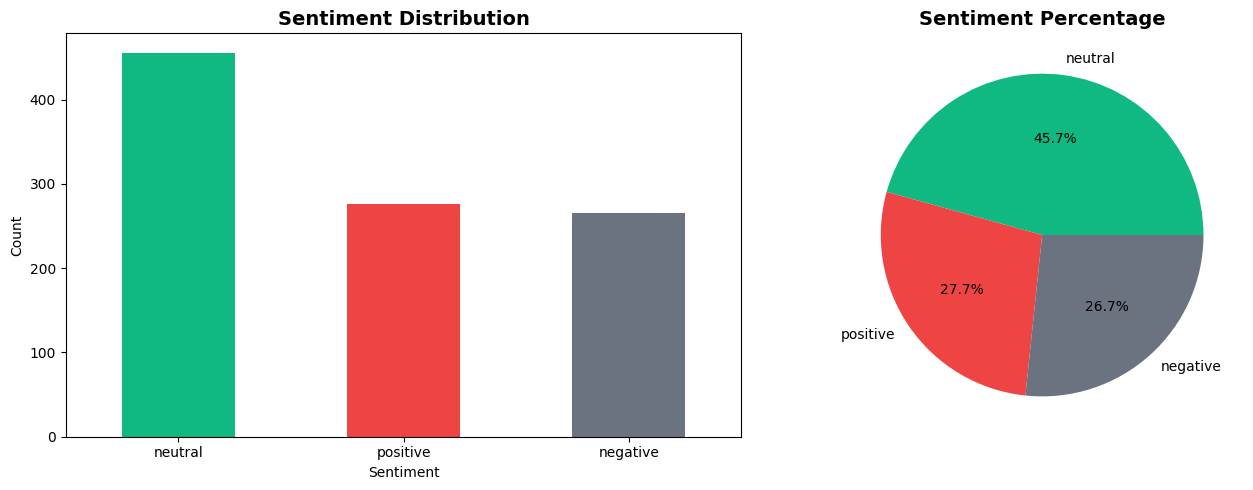

In [5]:
# SECTION 3: DATA PREPROCESSING & STANDARDIZATION
# ============================================================================

print("\n" + "="*70)
print("DATA PREPROCESSING & STANDARDIZATION")
print("="*70)

# Standardize columns
print("\n🔧 Standardizing column names...")

# Detect text and sentiment columns
text_cols = ['text', 'Text', 'review', 'Review', 'comment', 'Comment', 'tweet', 'Tweet', 'message', 'Message']
sentiment_cols = ['sentiment', 'Sentiment', 'label', 'Label', 'class', 'Class', 'polarity', 'Polarity']

text_col = None
sentiment_col = None

for col in text_cols:
    if col in df.columns:
        text_col = col
        break

for col in sentiment_cols:
    if col in df.columns:
        sentiment_col = col
        break

# Standardize
if text_col and sentiment_col:
    df = df[[text_col, sentiment_col]].copy()
    df.columns = ['text', 'sentiment']
    print(f"✅ Using columns: '{text_col}' → 'text', '{sentiment_col}' → 'sentiment'")
elif df.shape[1] >= 4:
    # Twitter format: typically [id, entity, sentiment, text]
    df = df.iloc[:, [3, 2]].copy()
    df.columns = ['text', 'sentiment']
    print("✅ Extracted text and sentiment from Twitter format")
elif df.shape[1] >= 2:
    df = df.iloc[:, :2].copy()
    df.columns = ['text', 'sentiment']
    print("✅ Using first two columns")

# Clean sentiment labels
print("\n🧹 Normalizing sentiment labels...")
print(f"Original values: {df['sentiment'].unique()}")

sentiment_map = {
    # Positive
    'Positive': 'positive', 'positive': 'positive', 'pos': 'positive', 
    'POS': 'positive', '1': 'positive', 1: 'positive', 4: 'positive',
    
    # Negative
    'Negative': 'negative', 'negative': 'negative', 'neg': 'negative',
    'NEG': 'negative', '0': 'negative', 0: 'negative',
    
    # Neutral
    'Neutral': 'neutral', 'neutral': 'neutral', 'neu': 'neutral',
    'NEU': 'neutral', '2': 'neutral', 2: 'neutral', 3: 'neutral',
    'Irrelevant': 'neutral', 'irrelevant': 'neutral'
}

df['sentiment'] = df['sentiment'].map(sentiment_map)
df = df[df['sentiment'].notna()].copy()

print(f"Normalized values: {df['sentiment'].unique()}")

# Clean data
print("\n🧹 Cleaning data...")
print(f"Original size: {len(df):,}")
df = df.drop_duplicates()
print(f"After deduplication: {len(df):,}")
df = df.dropna()
print(f"After removing NaN: {len(df):,}")

# Distribution
print("\n📊 Sentiment Distribution:")
print(df['sentiment'].value_counts())
print("\nPercentage:")
print((df['sentiment'].value_counts(normalize=True) * 100).round(2))

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

df['sentiment'].value_counts().plot(kind='bar', ax=axes[0], color=['#10b981', '#ef4444', '#6b7280'])
axes[0].set_title('Sentiment Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Sentiment')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=0)

df['sentiment'].value_counts().plot(kind='pie', ax=axes[1], autopct='%1.1f%%', 
                                    colors=['#10b981', '#ef4444', '#6b7280'])
axes[1].set_title('Sentiment Percentage', fontsize=14, fontweight='bold')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

In [7]:
 #SECTION 4: TEXT PREPROCESSING
# ============================================================================

print("\n" + "="*70)
print("TEXT PREPROCESSING")
print("="*70)

import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

class TextPreprocessor:
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
        self.stop_words = set(stopwords.words('english'))
        self.stop_words -= {'no', 'not', 'nor', 'neither', 'never', 'none'}
    
    def preprocess(self, text):
        if pd.isna(text):
            return ""
        
        text = str(text).lower()
        text = re.sub(r'http\S+|www\S+|https\S+', '', text)
        text = re.sub(r'<.*?>', '', text)
        text = re.sub(r'@\w+|#\w+', '', text)
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        text = ' '.join(text.split())
        
        try:
            tokens = word_tokenize(text)
        except:
            tokens = text.split()
        
        tokens = [self.lemmatizer.lemmatize(w) for w in tokens if w not in self.stop_words]
        return ' '.join(tokens)

preprocessor = TextPreprocessor()

print("\n🔧 Processing texts...")
df['clean_text'] = df['text'].apply(preprocessor.preprocess)

print("\n" + "="*70)
print("PREPROCESSING EXAMPLES")
print("="*70)
for i in range(min(5, len(df))):
    print(f"\nExample {i+1}:")
    print(f"Original: {df['text'].iloc[i][:80]}...")
    print(f"Cleaned:  {df['clean_text'].iloc[i][:80]}...")

df = df[df['clean_text'].str.strip() != ''].copy()
print(f"\n✅ Final dataset size: {len(df):,} rows")


TEXT PREPROCESSING

🔧 Processing texts...

PREPROCESSING EXAMPLES

Example 1:
Original: BBC News - Amazon boss Jeff Bezos rejects claims company acted like a 'drug deal...
Cleaned:  bbc news amazon bos jeff bezos reject claim company acted like drug dealer bbcco...

Example 2:
Original: @Microsoft Why do I pay for WORD when it functions so poorly on my @SamsungUS Ch...
Cleaned:  pay word function poorly chromebook...

Example 3:
Original: CSGO matchmaking is so full of closet hacking, it's a truly awful game....
Cleaned:  csgo matchmaking full closet hacking truly awful game...

Example 4:
Original: Now the President is slapping Americans in the face that he really did commit an...
Cleaned:  president slapping american face really commit unlawful act acquittal discover g...

Example 5:
Original: Hi @EAHelp I’ve had Madeleine McCann in my cellar for the past 13 years and the ...
Cleaned:  hi ive madeleine mccann cellar past year little sneaky thing escaped whilst load...

✅ Final datas

In [8]:
# SECTION 5: TRAIN-TEST SPLIT & TF-IDF
# ============================================================================

print("\n" + "="*70)
print("FEATURE EXTRACTION")
print("="*70)

X = df['clean_text']
y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\n✅ Split complete:")
print(f"   Train: {len(X_train):,} | Test: {len(X_test):,}")

# TF-IDF
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2), min_df=2, max_df=0.8)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print(f"\n📊 TF-IDF Features:")
print(f"   Shape: {X_train_tfidf.shape}")


FEATURE EXTRACTION

✅ Split complete:
   Train: 798 | Test: 200

📊 TF-IDF Features:
   Shape: (798, 1355)


In [9]:
# SECTION 6: MODEL TRAINING
# ============================================================================

print("\n" + "="*70)
print("TRAINING MODELS")
print("="*70)

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'),
    'Naive Bayes': MultinomialNB(alpha=0.1),
    'SVM': LinearSVC(random_state=42, max_iter=1000, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
}

results = {}
trained_models = {}

for name, model in models.items():
    print(f"\n{'='*70}")
    print(f"Training {name}...")
    
    model.fit(X_train_tfidf, y_train)
    trained_models[name] = model
    
    y_pred = model.predict(X_test_tfidf)
    
    acc = accuracy_score(y_test, y_pred)
    p, r, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted', zero_division=0)
    
    results[name] = {'accuracy': acc, 'precision': p, 'recall': r, 'f1': f1, 'predictions': y_pred}
    
    print(f"\n📊 Results:")
    print(f"   Accuracy:  {acc:.4f}")
    print(f"   Precision: {p:.4f}")
    print(f"   Recall:    {r:.4f}")
    print(f"   F1-Score:  {f1:.4f}")


TRAINING MODELS

Training Logistic Regression...

📊 Results:
   Accuracy:  0.5200
   Precision: 0.5264
   Recall:    0.5200
   F1-Score:  0.5212

Training Naive Bayes...

📊 Results:
   Accuracy:  0.5200
   Precision: 0.5194
   Recall:    0.5200
   F1-Score:  0.5188

Training SVM...

📊 Results:
   Accuracy:  0.4700
   Precision: 0.4733
   Recall:    0.4700
   F1-Score:  0.4709

Training Random Forest...

📊 Results:
   Accuracy:  0.4650
   Precision: 0.4650
   Recall:    0.4650
   F1-Score:  0.4650



MODEL COMPARISON

📊 Performance Summary:
                     Accuracy  Precision  Recall  F1-Score
Logistic Regression     0.520   0.526445   0.520  0.521160
Naive Bayes             0.520   0.519384   0.520  0.518801
SVM                     0.470   0.473329   0.470  0.470918
Random Forest           0.465   0.465000   0.465  0.465000

🏆 Best Model: Logistic Regression (0.5200)


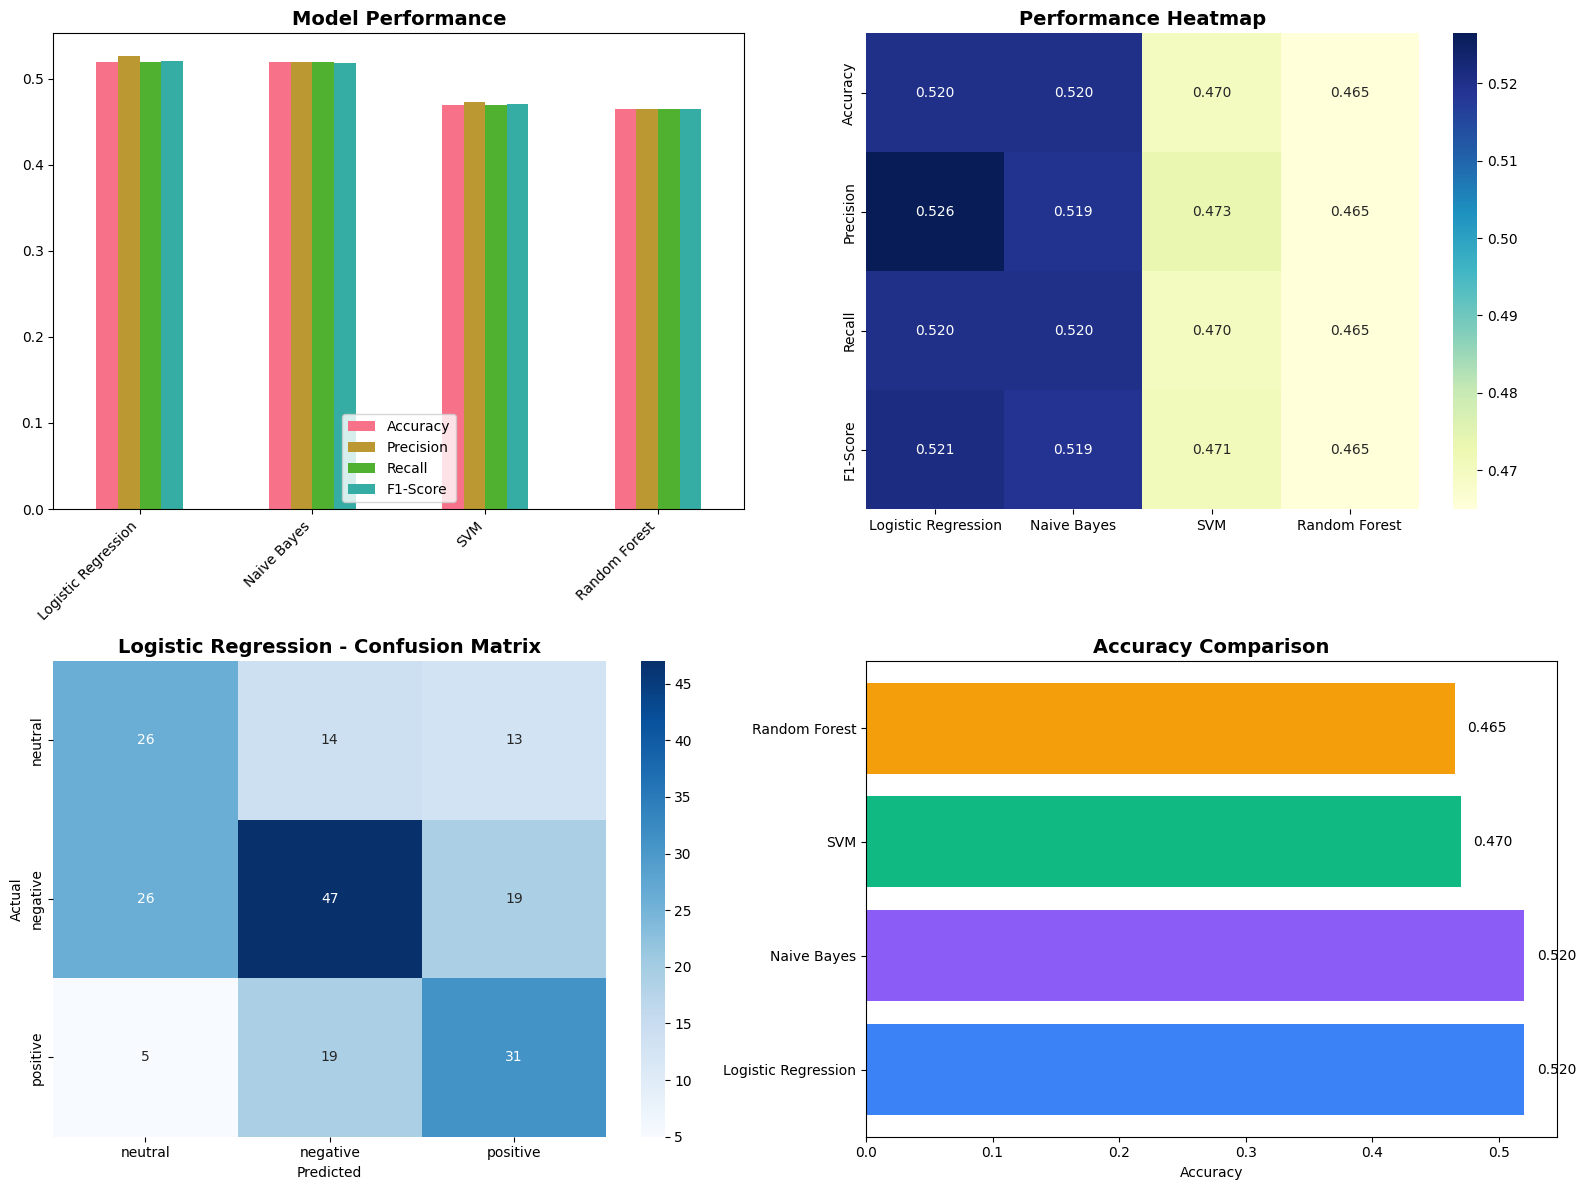

In [10]:
# SECTION 7: COMPARISON & VISUALIZATION
# ============================================================================

print("\n" + "="*70)
print("MODEL COMPARISON")
print("="*70)

comparison_df = pd.DataFrame({
    m: [results[m]['accuracy'], results[m]['precision'], results[m]['recall'], results[m]['f1']]
    for m in results.keys()
}, index=['Accuracy', 'Precision', 'Recall', 'F1-Score']).T

print("\n📊 Performance Summary:")
print(comparison_df)

best_model = comparison_df['Accuracy'].idxmax()
print(f"\n🏆 Best Model: {best_model} ({comparison_df.loc[best_model, 'Accuracy']:.4f})")

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

comparison_df.plot(kind='bar', ax=axes[0, 0])
axes[0, 0].set_title('Model Performance', fontsize=14, fontweight='bold')
axes[0, 0].set_xticklabels(axes[0, 0].get_xticklabels(), rotation=45, ha='right')

sns.heatmap(comparison_df.T, annot=True, fmt='.3f', cmap='YlGnBu', ax=axes[0, 1])
axes[0, 1].set_title('Performance Heatmap', fontsize=14, fontweight='bold')

cm = confusion_matrix(y_test, results[best_model]['predictions'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1, 0],
            xticklabels=y.unique(), yticklabels=y.unique())
axes[1, 0].set_title(f'{best_model} - Confusion Matrix', fontsize=14, fontweight='bold')
axes[1, 0].set_ylabel('Actual')
axes[1, 0].set_xlabel('Predicted')

accs = [results[n]['accuracy'] for n in results.keys()]
axes[1, 1].barh(list(results.keys()), accs, color=['#3b82f6', '#8b5cf6', '#10b981', '#f59e0b'])
axes[1, 1].set_xlabel('Accuracy')
axes[1, 1].set_title('Accuracy Comparison', fontsize=14, fontweight='bold')
for i, v in enumerate(accs):
    axes[1, 1].text(v + 0.01, i, f'{v:.3f}', va='center')

plt.tight_layout()
plt.show()

In [11]:
# SECTION 8: SAVE MODELS
# ============================================================================

print("\n" + "="*70)
print("SAVING MODELS")
print("="*70)

import joblib

os.makedirs('models', exist_ok=True)

joblib.dump(trained_models[best_model], f'models/{best_model.replace(" ", "_").lower()}.pkl')
joblib.dump(tfidf, 'models/tfidf_vectorizer.pkl')
joblib.dump(preprocessor, 'models/preprocessor.pkl')

comparison_df.to_csv('models/results.csv')

print("✅ Models saved to 'models/' directory")
print("\n🎉 Training Complete!")
print(f"   Best Model: {best_model}")
print(f"   Accuracy: {comparison_df.loc[best_model, 'Accuracy']:.4f}")


SAVING MODELS
✅ Models saved to 'models/' directory

🎉 Training Complete!
   Best Model: Logistic Regression
   Accuracy: 0.5200
